# Exploring the UD tagset with Hidden Markov Model
---
### Introduction

In this notebook, we will use the [Pomegranate](http://pomegranate.readthedocs.io/en/latest/index.html) library to build a simple Hidden Markov Model for part-of-speech tagging.
 
The goal here is breadth rather than depth: we want to cover as many languages in the UD tagset as possible, therefore we did not implement additional features like:
- Laplace Smoothing [Wiki Link](https://en.wikipedia.org/wiki/Additive_smoothing) 
    
- Backoff Smoothing [Speech & Language Processing Ch. 4,9,10](https://web.stanford.edu/~jurafsky/slp3/) 

- Extending to Trigrams [Trigram Paper](http://www.coli.uni-saarland.de/~thorsten/publications/Brants-ANLP00.pdf)


આ પોથીમાં આપણે વિવિધ ભાષાઓમાં શબ્દ ભેદ (પાર્ટ્સ ઓફ સ્પીચ) ઉકેલવાનું કામ હિડેન માર્કોવ મોડેલ (HMM) વડે કરીશું. 

અહીં દાડમ લાઇબ્રેરી [Pomegranate](http://pomegranate.readthedocs.io/en/latest/index.html) વાપરવામાં આવી છે.

આપણું લક્ષ્ય ઊંડાણ ને બદલે વિસ્તારનો છે, એટલા માટે નીચે આપેલ ગુણવિશેષનો સમાવેશ નથી: 
- લાપ્લેસ નિયમિતકારણ [વિકિપીડિયા](https://en.wikipedia.org/wiki/Additive_smoothing) 
    
- બેકઓફ નિયમિતકરણ [ચોંપડી પાઠ 4,9,10](https://web.stanford.edu/~jurafsky/slp3/) 

- ટ્રાઇગ્રામ [સંશોધન પેપર](http://www.coli.uni-saarland.de/~thorsten/publications/Brants-ANLP00.pdf)


<hr>

### Preprocessing and imports
We scan the entire UD folder to read in all the names of the respective language subdirectories, and prune out datasets that don't have train sets. Lack of a dev set is tolerated, as dev sets are fused to the training set, given the lack of iterative training in our HMM implementation. 

We need the following libraries installed:
1. Pomegranate
2. Numpy
3. Collections
4. pyconll

In addition, helper functions are found in data_prep.py and hmm_utils.py. Make sure you have these files in the same directory as this notebook!

In [3]:
# Jupyter "magic methods" -- only need to be run once per kernel restart
%load_ext autoreload
%autoreload 1

In [4]:
from collections import Counter
from pomegranate import HiddenMarkovModel, DiscreteDistribution, State
import numpy as np
from data_prep import *
from hmm_utils import *
import os
import fnmatch
import re
import pandas as pd
UD_PATH = 'C:/Users/DELL/Downloads/ud-treebanks-v2.6/ud-treebanks-v2.6/'

In [12]:
#store all languages with a train conllu file as tuples language_dirs. 
#First element of the tuple is the directory name, second element is the prefix before each conllu file
language_dirs = []
subdirs = os.listdir(UD_PATH)
for subdir in subdirs:
    for file in os.listdir(UD_PATH+subdir):
        if fnmatch.fnmatch(file, '*train.conllu'):
            file_prefix = re.compile('^.*(?=(train\.conllu))').search(file).group()
            language_dirs.append((subdir+'/', file_prefix))
            break

### HMM Tagger

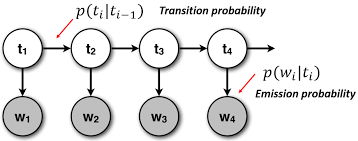
<center>(Image courtesy: Georgetown University ENLP Lectures)</center>

As shown in the figure above, each word $w_i$ has a corresponding tag $t_i$. The assumption is that the current tag determines directly the next tag, and once we know the tag we predict the word $w_i$ that could have occurred in the spot corresponding to the tag $t_i$. This arrow-based representation of a probability model is called a *graphical representation*. In the function `HMM_tag()` given below, we search for the 'train', 'dev' and 'test' conll files present in a given subdirectory `subdir` that have the file prefix `file_prefix`. Tuples of `subdir` and `file_prefix` are stored in the list variable *language_dirs*.

In [13]:
def HMM_tag(UD_PATH, subdir, file_prefix):
    #prepare train and test data, refer to data_prep.py for more details on "create_dataset"
    tag_list, word_list, X_train, Y_train, X_test, Y_test = create_dataset(UD_PATH, subdir, file_prefix)
    #create vocabulary by selecting the unique elements in word_list
    vocab = list(np.unique([x for x in word_list if x != None]))
    #P(word|tag)=C(word, tag)/C(tag) = emission_counts[tag][word]/unigram_counts[tag]
    emission_counts = pair_counts(tag_list, word_list)
    unigram_counts = Counter(tag_list)
    #P(t_{i+1}|t_i)=C(t_{i},t_{i+1})/C(t_{i}) = bigram_counts[(t_{i},t_{i+1})]/unigram_counts[t_{i}]
    bigram_counts = Counter([(tag_list[i],tag_list[i+1]) for i in range(len(word_list)-1)])
    #calculate counts for starting/ending with a certain tag
    start_counts = Counter([sentence[0] for sentence in Y_train])
    end_counts = Counter([sentence[-1] for sentence in Y_train])
    #Initialize a Pomrgranate HMM model
    basic_model = HiddenMarkovModel(name="hmm-tagger")
    #add HMM states corresponding to each tag
    cnt = 0
    states = []
    tags = list(unigram_counts.keys()) #list of all tags
    for tag in tags:
        emissions = DiscreteDistribution({word: emission_counts[tag][word]/unigram_counts[tag] for word in emission_counts[tag].keys()})
        states.append(State(emissions, name=tag))
        basic_model.add_states(states[cnt])
        cnt += 1
    #add edge from model.start to each tag, each tag to model.end
    cnt = 0
    for tag in tags:
        basic_model.add_transition(basic_model.start, states[cnt], start_counts[tag]/unigram_counts[tag])
        basic_model.add_transition(states[cnt], basic_model.end, end_counts[tag]/unigram_counts[tag])
        cnt += 1
    #adding transitions between various states in the model
    for i in range(len(tags)):
        for j in range(len(tags)):
            basic_model.add_transition(states[i], states[j], bigram_counts[(tags[i],tags[j])]/unigram_counts[tags[i]])
    #model checking
    basic_model.bake()
    #calculate train and test accuracy
    train_acc = accuracy(X_train, Y_train, basic_model, vocab)
    test_acc = accuracy(X_test, Y_test, basic_model, vocab)
    return train_acc, test_acc, len(X_train), len(X_test), len(word_list), len(vocab)

In [14]:
# Iterate through all datasets (~100) and perform HMM tagging, calculate test/training accuracy.

#German-HDT takes too much time and chokes up RAM, so get rid of it; there are other German datasets to work with
language_dirs.remove(('UD_German-HDT/', 'de_hdt-ud-'))

#initialize results DataFrame
results = pd.DataFrame(columns=['TrainAcc', 'TestAcc', 'TrainLength', 'TestLength', 'NumWords', 'NumVocab'])

#iterate through each dataset and calculating train and test accuracy for HMM based tagging
for subdir, file_prefix in language_dirs:
    results.loc[subdir] = HMM_tag(UD_PATH, subdir, file_prefix)
    print(results.loc[subdir])

TrainAcc           0.980505
TestAcc            0.923100
TrainLength     1316.000000
TestLength       425.000000
NumWords       39211.000000
NumVocab        4423.000000
Name: UD_Afrikaans-AfriBooms/, dtype: float64
TrainAcc            0.931551
TestAcc             0.816928
TrainLength     11477.000000
TestLength       1306.000000
NumWords       182030.000000
NumVocab        12100.000000
Name: UD_Ancient_Greek-Perseus/, dtype: float64
TrainAcc            0.964709
TestAcc             0.949527
TrainLength     15015.000000
TestLength       1047.000000
NumWords       200685.000000
NumVocab         9137.000000
Name: UD_Ancient_Greek-PROIEL/, dtype: float64
TrainAcc            0.343521
TestAcc             0.338337
TrainLength     15790.000000
TestLength       1963.000000
NumWords       757062.000000
NumVocab         4613.000000
Name: UD_Arabic-NYUAD/, dtype: float64
TrainAcc            0.871067
TestAcc             0.847317
TrainLength      6076.000000
TestLength        680.000000
NumWords      

Dev set not found, no worries! Train set must be good enough.
TrainAcc           0.893159
TestAcc            0.828807
TrainLength      600.000000
TestLength       400.000000
NumWords       16707.000000
NumVocab        3018.000000
Name: UD_Galician-TreeGal/, dtype: float64
TrainAcc            0.942002
TestAcc             0.886299
TrainLength     13815.000000
TestLength        977.000000
NumWords       281064.000000
NumVocab        41665.000000
Name: UD_German-GSD/, dtype: float64
TrainAcc           0.963948
TestAcc            0.950677
TrainLength     3388.000000
TestLength      1029.000000
NumWords       45138.000000
NumVocab        3070.000000
Name: UD_Gothic-PROIEL/, dtype: float64
TrainAcc           0.965071
TestAcc            0.923640
TrainLength     1663.000000
TestLength       456.000000
NumWords       54187.000000
NumVocab        5741.000000
Name: UD_Greek-GDT/, dtype: float64
TrainAcc            0.786980
TestAcc             0.739975
TrainLength      5242.000000
TestLength       

Dev set not found, no worries! Train set must be good enough.
TrainAcc           0.989858
TestAcc            0.775751
TrainLength      320.000000
TestLength       637.000000
NumWords       10156.000000
NumVocab        1944.000000
Name: UD_Old_Russian-RNC/, dtype: float64
TrainAcc            0.958899
TestAcc             0.916271
TrainLength     13337.000000
TestLength       1756.000000
NumWords       134421.000000
NumVocab         8399.000000
Name: UD_Old_Russian-TOROT/, dtype: float64
TrainAcc            0.925901
TestAcc             0.927180
TrainLength      4799.000000
TestLength        600.000000
NumWords       138089.000000
NumVocab         6955.000000
Name: UD_Persian-Seraji/, dtype: float64
TrainAcc            0.979829
TestAcc             0.929301
TrainLength     13775.000000
TestLength       1727.000000
NumWords       117855.000000
NumVocab        14933.000000
Name: UD_Polish-LFG/, dtype: float64
TrainAcc            0.951613
TestAcc             0.913337
TrainLength     17723.0000

### Results and analysis
Of the 100 language datasets we analyzed, we focus on a chosen few (~20) and display the training and test accuracy as a bar chart. We also plot the sizes of the training data in terms of the number of words and the size of the vocabulary to get a sense of which datasets are resource-rich and which aren't. Surprisingly, the performance of HMM is good even for low resources, when seen by the standards of routine NLP tasks like question answering and machine translation.

In [50]:
#Convert columns such as NumVocab from decimal into integer (int64) format 
results = results.astype({'TrainLength':'int64', 'TestLength':'int64', 'NumWords':'int64', 'NumVocab':'int64'})
#store dataset names as a separate column too
results['index'] = results.index
#Take a look at the first few rows of the results dataframe
results.head()

(110, 7)

In [97]:
plot_datasets = ['UD_Czech-PDT/', 'UD_Russian-SynTagRus/', 'UD_Spanish-AnCora/', 
           'UD_Catalan-AnCora/', 'UD_Romanian-Nonstandard/', 'UD_French-GSD/', 'UD_Estonian-EDT/', 
           'UD_Latin-ITTB/', 'UD_Korean-Kaist/', 'UD_Polish-PDB/', 'UD_Hindi-HDTB/', 'UD_Italian-ISDT/', 
           'UD_Arabic-PADT/', 'UD_German-GSD/', 'UD_Norwegian-Bokmaal/', 'UD_Portuguese-Bosque/',
           'UD_English-EWT/', 'UD_Dutch-Alpino/', 'UD_Latvian-LVTB/', 'UD_Hebrew-HTB/', 'UD_Finnish-TDT/',
           'UD_Japanese-GSD/', 'UD_Croatian-SET/', 'UD_Bulgarian-BTB/', 'UD_Persian-Seraji/', 'UD_Slovenian-SSJ/',
           'UD_Urdu-UDTB/', 'UD_Galician-CTG/', 'UD_Naija-NSC/', 'UD_Chinese-GSD/', 'UD_Indonesian-GSD/', 
           'UD_Ukrainian-IU/', 'UD_Basque-BDT/', 'UD_Slovak-SNK/', 'UD_Danish-DDT/',
           'UD_Serbian-SET/', 'UD_Swedish-Talbanken/', 'UD_Lithuanian-ALKSNIS/', 
           'UD_Irish-IDT/', 'UD_Greek-GDT/', 'UD_Turkish-IMST/', 'UD_Armenian-ArmTDP/', 'UD_Gothic-PROIEL/',
           'UD_Coptic-Scriptorium/', 'UD_Afrikaans-AfriBooms/', 'UD_Wolof-WTB/',
           'UD_Scottish_Gaelic-ARCOSG/', 'UD_Vietnamese-VTB/', 'UD_Hungarian-Szeged/',
           'UD_Uyghur-UDT/', 'UD_Sanskrit-Vedic/', 'UD_North_Sami-Giella/', 
           'UD_Welsh-CCG/', 'UD_Tamil-TTB/', 'UD_Belarusian-HSE/',
           'UD_Marathi-UFAL/', 'UD_Kazakh-KTB/', 'UD_Upper_Sorbian-UFAL/',
           'UD_Kurmanji-MG/', 'UD_Buryat-BDT/', 'UD_Livvi-KKPP/'
          ]


In [129]:
results.loc['UD_Kurmanji-MG/'] = HMM_tag(UD_PATH, 'UD_Kurmanji-MG/', 'kmr_mg-ud-') 
print(results.loc['UD_Kurmanji-MG/'])
results.loc['UD_Kazakh-KTB/'] = HMM_tag(UD_PATH, 'UD_Kazakh-KTB/', 'kk_ktb-ud-') 
print(results.loc['UD_Kazakh-KTB/'])
results.loc['UD_Livvi-KKPP/'] = HMM_tag(UD_PATH, 'UD_Livvi-KKPP/', 'olo_kkpp-ud-')
print(results.loc['UD_Livvi-KKPP/'])
results.loc['UD_Buryat-BDT/'] = HMM_tag(UD_PATH, 'UD_Buryat-BDT/', 'bxr_bdt-ud-') 
print(results.loc['UD_Buryat-BDT/'])
results.loc['UD_Upper_Sorbian-UFAL/'] = HMM_tag(UD_PATH, 'UD_Upper_Sorbian-UFAL/', 'hsb_ufal-ud-') 
print(results.loc['UD_Upper_Sorbian-UFAL/'])




Dev set not found, no worries! Train set must be good enough.
TrainAcc           0.969277
TestAcc            0.847107
TrainLength      734.000000
TestLength        20.000000
NumWords       10090.000000
NumVocab        1785.000000
Name: UD_Kurmanji-MG/, dtype: float64
Dev set not found, no worries! Train set must be good enough.
TrainAcc           0.939460
TestAcc            0.707495
TrainLength     1047.000000
TestLength        31.000000
NumWords       10142.000000
NumVocab        2338.000000
Name: UD_Kazakh-KTB/, dtype: float64
Dev set not found, no worries! Train set must be good enough.
TrainAcc          0.973790
TestAcc           0.604167
TrainLength     106.000000
TestLength       19.000000
NumWords       1488.000000
NumVocab        524.000000
Name: UD_Livvi-KKPP/, dtype: float64
Dev set not found, no worries! Train set must be good enough.
TrainAcc           0.966806
TestAcc            0.810458
TrainLength      908.000000
TestLength        19.000000
NumWords       10032.000000
Nu

In [130]:
#cherry pick rows to plot histogram; I focused on languages with the most amount of training data, 
#measured in terms of number of words
results_shrink = results.loc[plot_datasets]
#use regex to keep extract language names from the subdirectories, viz. 'UD_Kurmanji-MG/' --> 'Kurmanji'
plot_languages = [re.compile('(?<=\_)(.*)(?=\-)').search(x).group() for x in plot_datasets]
#set index of rows to plot_languages values, for easy plotting
results_shrink.index = plot_languages

Visualizing this data is a mundane yet important task. I plot here the bar charts of train and test accuracies for the various languages in the `plot_datasets` list. As you can see, there are many European languages among this data. A nice thing to make bar plots less cluttered, I am dividing the languages into 2 sets: European and non-European.

In [131]:
Europe = ['Czech', 'Russian', 'Spanish', 'Catalan', 'Romanian', 'French', 'Estonian', 'Latin', 'Polish', 'Italian', 'German', 'Norwegian', 'Portuguese', 'English', 'Dutch', 'Latvian', 'Finnish', 'Croatian', 'Bulgarian', 'Slovenian', 'Galician', 'Chinese', 'Basque', 'Slovak', 'Danish', 'Serbian', 'Swedish', 'Lithuanian', 'Irish', 'Greek', 'Gothic', 'Scottish_Gaelic', 'Hungarian', 'North_Sami', 'Welsh', 'Upper_Sorbian', 'Belarusian', 'Livvi']
results_shrink_Europe = results_shrink.loc[Europe]
results_shrink_NonEurope = results_shrink.drop(index=Europe)

In [136]:
results1 = results.copy(deep=True)
results1['index'] = results1.index
list(results1.sort_values(by=['NumWords','index'], ascending=False).index)

['UD_Czech-PDT/',
 'UD_Japanese-BCCWJ/',
 'UD_Russian-SynTagRus/',
 'UD_Arabic-NYUAD/',
 'UD_French-FTB/',
 'UD_Spanish-AnCora/',
 'UD_Czech-CAC/',
 'UD_Catalan-AnCora/',
 'UD_Romanian-Nonstandard/',
 'UD_Spanish-GSD/',
 'UD_French-GSD/',
 'UD_Estonian-EDT/',
 'UD_Latin-ITTB/',
 'UD_Korean-Kaist/',
 'UD_Polish-PDB/',
 'UD_Hindi-HDTB/',
 'UD_Portuguese-GSD/',
 'UD_Italian-ISDT/',
 'UD_Arabic-PADT/',
 'UD_German-GSD/',
 'UD_Norwegian-Bokmaal/',
 'UD_Norwegian-Nynorsk/',
 'UD_Italian-VIT/',
 'UD_Portuguese-Bosque/',
 'UD_English-EWT/',
 'UD_Latin-LLCT/',
 'UD_Romanian-RRT/',
 'UD_Ancient_Greek-PROIEL/',
 'UD_Dutch-Alpino/',
 'UD_Latvian-LVTB/',
 'UD_Latin-PROIEL/',
 'UD_Hebrew-HTB/',
 'UD_Ancient_Greek-Perseus/',
 'UD_Finnish-TDT/',
 'UD_Japanese-GSD/',
 'UD_Croatian-SET/',
 'UD_Old_French-SRCMF/',
 'UD_Czech-FicTree/',
 'UD_Finnish-FTB/',
 'UD_Bulgarian-BTB/',
 'UD_Persian-Seraji/',
 'UD_Old_Russian-TOROT/',
 'UD_Slovenian-SSJ/',
 'UD_Urdu-UDTB/',
 'UD_Classical_Chinese-Kyoto/',
 'UD_Gal

In [132]:
import plotly.graph_objects as go

fig1 = go.Figure(data=[
    go.Bar(name='Training Accuracy', x=results_shrink_Europe.index, y=results_shrink_Europe['TrainAcc']),
    go.Bar(name='Test Accuracy', x=results_shrink_Europe.index, y=results_shrink_Europe['TestAcc'])
])
# Change the bar mode
fig1.update_layout(barmode='group', yaxis = dict(tickmode = 'linear',tick0 = 0,dtick = 0.1), title='European Languages')
fig1.show()

fig2 = go.Figure(data=[
    go.Bar(name='Training Accuracy', x=results_shrink_NonEurope.index, y=results_shrink_NonEurope['TrainAcc']),
    go.Bar(name='Test Accuracy', x=results_shrink_NonEurope.index, y=results_shrink_NonEurope['TestAcc'])
])
# Change the bar mode
fig2.update_layout(barmode='group', yaxis = dict(tickmode = 'linear',tick0 = 0,dtick = 0.1), title='Non-European Languages')
fig2.show()

### Conclusions:
There are some languages that don't do that well, for example, Livvi. The languages have been roughly sorted according to the total number of words (allowing repetitions) encountered during HMM training. This is very likely due to lack of training data. Livvi (KKPP), figuring at the bottom of the list, has only 106 training sentences, whereas Czech (PDT), appearing at the top of the European list, has 68496 training sentences. Assuming that each sentence in Livvi packs roughly as much info as a sentence in Czech, one should expect the Czech HMM to do better. The interesting point, however, is that the treshold to hit a 85%+ test accuracy isn't that high. 

On the other hand, one shouldn't read too much into the finer differences in the results shown above, as the UD data has deficiencies such as incomplete annotation. In some cases such as Upper Sorbian, the test data file had 30 times as many sentences as the training data file (dev data didn't exist), which is outright absurd! In most of such cases, I swapped the train and test data to make things smoother. Here are the languages where this was done:

1. Upper Sorbian
2. Livvi
3. Buryat
4. Kurmanji
5. Kazakh

Some datasets were discarded (e.g., Telugu) because of missing lemmatizations, etc.

#### As a general rule of thumb, investigate the dataset when you find really low accuracies!

In [138]:
results_shrink_Europe.loc['Upper_Sorbian']

TrainAcc           0.990965
TestAcc            0.858696
TrainLength      623.000000
TestLength        23.000000
NumWords       10736.000000
NumVocab        3002.000000
Name: Upper_Sorbian, dtype: float64

In [137]:
results.to_csv('results.csv')

In [140]:
import plotly.io as pio
pio.write_html(fig1, file='plots.html', auto_open=True)